In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pytz
import os
import patsy #for spline regression
import scipy #for non-negative least square 
import scipy as sp 
from scipy import stats
from scipy.optimize import nnls
from numpy.linalg import inv #for matrix and statistics
import scipy as sp
import math
import statsmodels.api as sm
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import sklearn.cluster
import sklearn.linear_model
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error
import sklearn.cluster
import sklearn.linear_model
from sklearn.svm import SVR
%matplotlib inline

In [2]:
#specify data source 
datasource = 'L'

In [3]:
#zipcode = '92562'
zipcode = '08641'

In [4]:
#mainDir = 'C:/Users/umnouyp/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
#mainDir = 'C:/Users/Tee/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis'
#we can choose which data to look at.
dataDir = mainDir + '/data/solar/' + datasource +'/' + zipcode +'/'
outputDir = mainDir + '/output/'+ datasource +'/' + zipcode +'/'

In [5]:
data = pd.read_csv(dataDir +'/training_data_fitted_adjusted.csv')
data['tsLocal'] = data['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

dsummary = pd.read_csv(outputDir+"/fitsummary.csv")
dsummary.Date = dsummary.Date.map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d").date())
FullModelCoef = pd.read_csv(outputDir+"/FullModelCoef.csv")

In [6]:
weatherdatasource = '/data/weather/weathersource/hourly/'
if (zipcode == '08641')|(zipcode =='08640'):
    weatherdata = pd.read_csv(mainDir+weatherdatasource+'08641_20132014.csv')
if (zipcode == '92562')|(zipcode =='92563'):
    weatherdata = pd.read_csv(mainDir+weatherdatasource+'92563_20132014.csv')

weatherdata['tsLocal'] = weatherdata.timestamp.map(lambda x: x[0:10] + " " + x[11:19])
#weatherdata.tsLocal = weatherdata.tsLocal.map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
if type(weatherdata.tsLocal[0])==str:
    weatherdata['tsLocal'] = weatherdata['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
weatherdata.drop(['timestamp','country','postal_code'], axis=1, inplace=True)

In [7]:
if weatherdata.shape[0]!=len(set(weatherdata['tsLocal'])):
    for i in range(weatherdata.shape[0]):
        if weatherdata.loc[i,'tsLocal'] == weatherdata.loc[(i+1),'tsLocal']:
            print weatherdata.loc[i,'tsLocal']

In [8]:
dsummary[:1]

,E,Rsq,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,Date,DBW,singlemax,PeakCheck,FirstCheck,SecondCheck,mE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-01,-355,NaN,False,False,False,4.742651


In [9]:
FullModelCoef[:1]

,DBW,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10
0,0,0.146378,0.415993,0.488299,0.645738,0.714671,0.729269,0.760784,0.76581,0.660012,0.647527,0.141794


Here we define power ratio, $r$, for each power reading. We add shift to avoid infinity.

In [10]:
#shift = 0.01
#data['r'] = (data.power+shift)/(data.mpower+shift)

In [11]:
data[:1]

,tsLocal,altitude,azimuth,power,numactivecomp,totalsize,s,DBW,mpower,r,expectedr
0,2013-01-01 07:30:00,1.11014,-301.362934,NaN,5,64.71819,-0.999743,-355,0.296,NaN,0.415969


# Basic time series construction with hourly volatility

Here we construct time series of power and power ratio. We add time without sun to create consistent time series. In addition, we add parallel values of previous 15 minute instances (-1, -2, ...) and previous day instances (y).

In [12]:
#specify scope
StartScopeDate = '2013-01-01'
EndScopeDate = '2015-01-01'
StartScopeTime =  datetime.datetime.strptime(StartScopeDate,"%Y-%m-%d")
EndScopeTime =  datetime.datetime.strptime(EndScopeDate,"%Y-%m-%d")

#Generate data frame from start to end for time series
tslist = []
nxt = StartScopeTime
while nxt < EndScopeTime:
    tslist.append(nxt)
    nxt += datetime.timedelta(minutes=15)
        
Scope = pd.DataFrame(0, index = np.arange(len(tslist)), columns = ['tsLocal'])
Scope['tsLocal'] = tslist

#Now we can merge using Scope Table as a backbone of data structure.
d = pd.merge(Scope,weatherdata,on=['tsLocal'], how = 'left') 



In [13]:
d.shape

(70080, 12)

In [14]:
#d[70000:]

In [15]:
for j in range(1,12):
    for i in range(0,d.shape[0]/4-1):
        if (type(d.iloc[4*i,j])!=pd.tslib.NaTType) & (type(d.iloc[4*(i+1),j])!=pd.tslib.NaTType):
        #d.iloc[4*(i+1),1]=float('NaN')
            d.iloc[4*i+1,j] = 0.75*d.iloc[4*i,j]+0.25*d.iloc[4*(i+1),j]
            d.iloc[4*i+2,j] = 0.50*d.iloc[4*i,j]+0.50*d.iloc[4*(i+1),j]
            d.iloc[4*i+3,j] = 0.25*d.iloc[4*i,j]+0.75*d.iloc[4*(i+1),j]

In [16]:
#Now we can merge our backbone + weather with solar data
d = pd.merge(d,data,on=['tsLocal'], how = 'left') 

In [17]:
#timeseries of previous timestamps
d['power-1'] = float('NaN')
d['mpower-1'] = float('NaN')
d['mpower-2'] = float('NaN')
d['mpower-3'] = float('NaN')
d['mpower-4'] = float('NaN')
d['power-2'] = float('NaN')
d['power-3'] = float('NaN')
d['power-4'] = float('NaN')
d['power-5'] = float('NaN')
d['power-6'] = float('NaN')
d['power_y-0'] = float('NaN')
d['power_y-1'] = float('NaN')
d['power_y-2'] = float('NaN')
d['r-1'] = float('NaN')
d['r-2'] = float('NaN')
d['r-3'] = float('NaN')
d['r-4'] = float('NaN')
d['r-5'] = float('NaN')
d['r-6'] = float('NaN')
d['r_y-0'] = float('NaN')
d['r_y-1'] = float('NaN')
d['r_y-2'] = float('NaN')
d.loc[1:d.shape[0],'r-1'] = list(d['r'].iloc[0:(d.shape[0]-1)])
d.loc[2:d.shape[0],'r-2'] = list(d['r'].iloc[0:(d.shape[0]-2)])
d.loc[3:d.shape[0],'r-3'] = list(d['r'].iloc[0:(d.shape[0]-3)])
d.loc[4:d.shape[0],'r-4'] = list(d['r'].iloc[0:(d.shape[0]-4)])
d.loc[5:d.shape[0],'r-5'] = list(d['r'].iloc[0:(d.shape[0]-5)])
d.loc[6:d.shape[0],'r-6'] = list(d['r'].iloc[0:(d.shape[0]-6)])
d.loc[1:d.shape[0],'mpower-1'] = list(d['mpower'].iloc[0:(d.shape[0]-1)])
d.loc[2:d.shape[0],'mpower-2'] = list(d['mpower'].iloc[0:(d.shape[0]-2)])
d.loc[3:d.shape[0],'mpower-3'] = list(d['mpower'].iloc[0:(d.shape[0]-3)])
d.loc[4:d.shape[0],'mpower-4'] = list(d['mpower'].iloc[0:(d.shape[0]-4)])
d.loc[1:d.shape[0],'power-1'] = list(d['power'].iloc[0:(d.shape[0]-1)])
d.loc[2:d.shape[0],'power-2'] = list(d['power'].iloc[0:(d.shape[0]-2)])
d.loc[3:d.shape[0],'power-3'] = list(d['power'].iloc[0:(d.shape[0]-3)])
d.loc[4:d.shape[0],'power-4'] = list(d['power'].iloc[0:(d.shape[0]-4)])
d.loc[5:d.shape[0],'power-5'] = list(d['power'].iloc[0:(d.shape[0]-5)])
d.loc[6:d.shape[0],'power-6'] = list(d['power'].iloc[0:(d.shape[0]-6)])

#24 hour shift = 24*4 shift in index. 'y' means yesterday
d.loc[96:d.shape[0],'r_y-0'] = list(d['r'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'r_y-1'] = list(d['r-1'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'r_y-2'] = list(d['r-2'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'r_y-3'] = list(d['r-3'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'r_y-4'] = list(d['r-4'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'power_y-0'] = list(d['power'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'power_y-1'] = list(d['power-1'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'power_y-2'] = list(d['power-2'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'power_y-3'] = list(d['power-3'].iloc[0:(d.shape[0]-96)])
d.loc[96:d.shape[0],'power_y-4'] = list(d['power-4'].iloc[0:(d.shape[0]-96)])

In [18]:
d['cldCvr-1'] = float('NaN')
d['dewPt-1'] = float('NaN')
d['feelsLike-1'] = float('NaN')
d['precip-1'] = float('NaN')
d['relHum-1'] = float('NaN')
d['sfcPres-1'] = float('NaN')
d['snowfall-1'] = float('NaN')
d['spcHum-1'] = float('NaN')
d['temp-1'] = float('NaN')
d['windSpd-1'] = float('NaN')
d['wetBulb-1'] = float('NaN')
d.loc[1:d.shape[0],'cldCvr-1'] = list(d['cldCvr'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'dewPt-1'] = list(d['dewPt'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'feelsLike-1'] = list(d['feelsLike'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'precip-1'] = list(d['precip'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'relHum-1'] = list(d['relHum'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'sfcPres-1'] = list(d['sfcPres'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'snowfall-1'] = list(d['snowfall'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'spcHum-1'] = list(d['spcHum'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'temp-1'] = list(d['temp'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'windSpd-1'] = list(d['windSpd'].iloc[0:(d.shape[0]-1)])
d.loc[1:d.shape[0],'wetBulb-1'] = list(d['wetBulb'].iloc[0:(d.shape[0]-1)])

In [19]:
#normalize weather value
d['cldCvr-1'] = (d['cldCvr-1']-np.min(d['cldCvr-1']))/(np.max(d['cldCvr-1'])-np.min(d['cldCvr-1']))
d['dewPt-1'] = (d['dewPt-1']-np.min(d['dewPt-1']))/(np.max(d['dewPt-1'])-np.min(d['dewPt-1']))
d['feelsLike-1'] = (d['feelsLike-1']-np.min(d['feelsLike-1']))/(np.max(d['feelsLike-1'])-np.min(d['feelsLike-1']))
d['precip-1'] = (d['precip-1']-np.min(d['precip-1']))/(np.max(d['precip-1'])-np.min(d['precip-1']))
d['relHum-1'] = (d['relHum-1']-np.min(d['relHum-1']))/(np.max(d['relHum-1'])-np.min(d['relHum-1']))
d['sfcPres-1'] = (d['sfcPres-1']-np.min(d['sfcPres-1']))/(np.max(d['sfcPres-1'])-np.min(d['sfcPres-1']))
d['snowfall-1'] = (d['snowfall-1']-np.min(d['snowfall-1']))/(np.max(d['snowfall-1'])-np.min(d['snowfall-1']))
d['spcHum-1'] = (d['spcHum-1']-np.min(d['spcHum-1']))/(np.max(d['spcHum-1'])-np.min(d['spcHum-1']))
d['temp-1'] = (d['temp-1']-np.min(d['temp-1']))/(np.max(d['temp-1'])-np.min(d['temp-1']))
d['windSpd-1'] = (d['windSpd-1']-np.min(d['windSpd-1']))/(np.max(d['windSpd-1'])-np.min(d['windSpd-1']))
d['wetBulb-1'] = (d['wetBulb-1']-np.min(d['wetBulb-1']))/(np.max(d['wetBulb-1'])-np.min(d['wetBulb-1']))


Let's compute rolling hourly volaitility (this is for 15 min interval)

In [20]:
#volatility derivative-based and persistence-based
#d['V-d'] = np.absolute(d['power-1']-4*d['power-2']+6*d['power-3']-4*d['power-4']+d['power-5'])
d['V-s'] = np.absolute(d['power-1']-d['power-2']/d['mpower-2']*d['mpower-1'])+\
            np.absolute(d['power-2']-d['power-3']/d['mpower-3']*d['mpower-2'])+\
             np.absolute(d['power-3']-d['power-4']/d['mpower-4']*d['mpower-3'])

Here we separate data for training and testing. Need this for autoregressive model.

In [21]:
Data = d
#select data for training and test
StartDate = datetime.date(2014,10,1)
TrainData = d[d.tsLocal.map(lambda x: x.date()) <StartDate].set_index('tsLocal')
TrainDateList = list(dsummary.Date[dsummary.Date<StartDate])
TestData = d[d.tsLocal.map(lambda x: x.date()) >=StartDate].set_index('tsLocal')

#Extra screening by high energy days
HighEnergyDayList = list(dsummary.Date[dsummary.E/dsummary.mE>0.9]) #for NJ
HighEnergyTestData = d[d.tsLocal.map(lambda x: (x.date()>=StartDate) & (x.date() in HighEnergyDayList))].set_index('tsLocal')

Before moving on, let's show that there is no poor correlation between 24 hour apart value.

In [22]:
from sklearn import datasets, linear_model
# Create linear regression object
regr1 = linear_model.LinearRegression()
regr2 = linear_model.LinearRegression()
check = d[['power','power_y-0','r','r_y-0']].dropna()

# Train the model using the training sets
regr1.fit(check[['power']], check[['power_y-0']])
regr2.fit(check[['r']], check[['r_y-0']])
[regr1.score(check[['power']], check[['power_y-0']]),regr2.score(check[['r']], check[['r_y-0']])]

[0.39077765150704846, 0.095941519597400493]

So we don't need to refer to previous 24 hours value.

Let's look at the color map of normalized power and r

(350, 750)

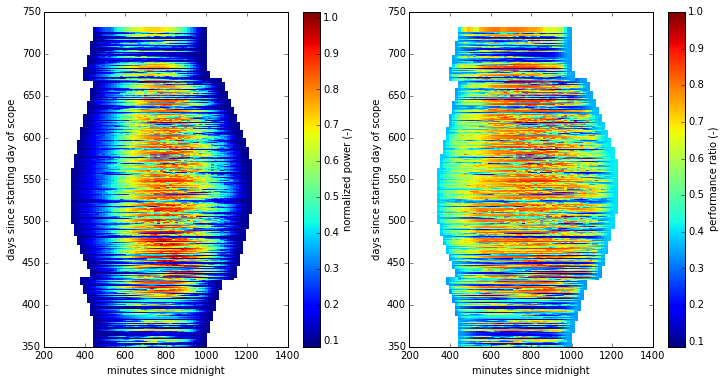

In [23]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import pylab
Ref = d.tsLocal.iloc[0].date()
x = d.tsLocal.map(lambda x: x.hour*60 + x.minute)
y = d.tsLocal.map(lambda x: (x.date()-Ref).days)
plt.clf()
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121)
plt.scatter(x, y, c= d.power, edgecolors='none',marker=',',s=20)
ax1.set_xlabel('minutes since midnight')
ax1.set_ylabel('days since starting day of scope')
cbar = plt.colorbar(ax=ax1)
cbar.ax.set_ylabel('normalized power (-)')
ax1.set_ylim(350,750)

ax1 = fig.add_subplot(122)
plt.scatter(x, y, c= d.r, edgecolors='none',marker=',',s=20)
ax1.set_xlabel('minutes since midnight')
ax1.set_ylabel('days since starting day of scope')
cbar = plt.colorbar(ax=ax1)
cbar.ax.set_ylabel('performance ratio (-)')
ax1.set_ylim(350,750)


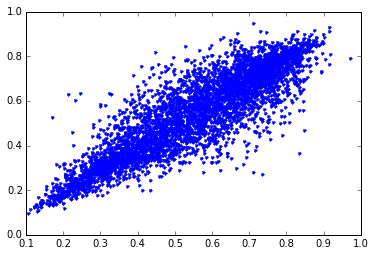

In [24]:
d = Data
i=1
plt.plot(d['r-1'][(d['V-s']>=0.1*i)&(d['V-s']<=0.1*(i+1))],d['r'][(d['V-s']>=0.1*i)&(d['V-s']<=0.1*(i+1))],'.')

#15-minute rolling prediction: Basic and advanced models

Before doing any model, make a consistent train/test by randomly assign 80/20

In [25]:
d = Data
#Truly random
#l = np.random.permutation(d.shape[0])
#d = d.iloc[l].reset_index(drop=True)
#offset = int(d.shape[0] * 0.8)

#Assign specific period
StartDate = datetime.date(2014,10,1)
offset = d[d.tsLocal.map(lambda x: x.date()) <StartDate].shape[0]

Data_train = d[:offset]
Data_test = d[offset:]

In [26]:
#For bin reference
numbins = int(math.ceil(np.max(d['V-s'])/0.1))
meandifflist = [0]*numbins
maxdifflist = [0]*numbins
middlebinvalue = [0.1*i+0.05 for i in range(0,numbins)]

## Model Reference: Persistence

In [27]:
d_train = Data_train
d_test = Data_test
feature_names = ['r-1']
d_train = d_train.loc[:,['tsLocal','power','mpower','r','V-s']+feature_names].dropna()
d_test = d_test.loc[:,['tsLocal','power','mpower','r','V-s']+feature_names].dropna()
X_train, y_train = d_train.loc[:,feature_names], d_train.loc[:,'r']
X_test, y_test = d_test.loc[:,feature_names], d_test.loc[:,'r']

In [28]:
mod = sklearn.linear_model.LinearRegression().fit(X_train,y_train)
d_test['power_predict'] = d_test['r-1']*d_test.loc[:,'mpower']
d_test['power_predict'] = d_test['power_predict']*(d_test['power_predict']<d_test['mpower'])+d_test['mpower']*(d_test['power_predict']>=d_test['mpower'])
d_test['power_predict'] = 0*(d_test['power_predict']<0)+d_test['power_predict']*(d_test['power_predict']>=0)
l = d_test.loc[:,'power']-d_test['power_predict']
[mean_persistent,max_persistent] = [np.mean(np.absolute(l)),np.max(np.absolute(l))]

In [29]:
d=d_test
meandifflist = [0]*numbins
maxdifflist = [0]*numbins
for i in range(0,numbins):
    dd = d[(d['V-s']>=0.1*i)&(d['V-s']<=0.1*(i+1))]
    l = dd['power']-dd['power_predict']
    meandifflist[i] = np.mean(np.absolute(l))
    maxdifflist[i] = np.max(np.absolute(l))

maxdifflist_persistent = maxdifflist
meandifflist_persistent = meandifflist

## Simple model: Auto-regression 1

In [30]:
d_train = Data_train
d_test = Data_test
feature_names = ['r-1']
d_train = d_train.loc[:,['tsLocal','power','mpower','r','V-s']+feature_names].dropna()
d_test = d_test.loc[:,['tsLocal','power','mpower','r','V-s']+feature_names].dropna()
X_train, y_train = d_train.loc[:,feature_names], d_train.loc[:,'r']
X_test, y_test = d_test.loc[:,feature_names], d_test.loc[:,'r']

In [31]:
mod = sklearn.linear_model.LinearRegression().fit(X_train,y_train)
d_test['power_predict'] = (mod.predict(X_test))*d_test.loc[:,'mpower']
d_test['power_predict'] = d_test['power_predict']*(d_test['power_predict']<d_test['mpower'])+d_test['mpower']*(d_test['power_predict']>=d_test['mpower'])
d_test['power_predict'] = 0*(d_test['power_predict']<0)+d_test['power_predict']*(d_test['power_predict']>=0)
l = d_test.loc[:,'power']-d_test['power_predict']
[mean_AR1,max_AR1] = [np.mean(np.absolute(l)),np.max(np.absolute(l))]

In [32]:
d=d_test
meandifflist = [0]*numbins
maxdifflist = [0]*numbins
for i in range(0,numbins):
    dd = d[(d['V-s']>=0.1*i)&(d['V-s']<=0.1*(i+1))]
    l = dd['power']-dd['power_predict']
    meandifflist[i] = np.mean(np.absolute(l))
    maxdifflist[i] = np.max(np.absolute(l))
    
maxdifflist_AR1 = maxdifflist
meandifflist_AR1 = meandifflist

## Simple model: Auto-regression 2

This is a reference.

In [33]:
d_train = Data_train
d_test = Data_test
feature_names = ['r-1','r-2']
d_train = d_train.loc[:,['tsLocal','power','mpower','r','V-s']+feature_names].dropna()
d_test = d_test.loc[:,['tsLocal','power','mpower','r','V-s']+feature_names].dropna()
X_train, y_train = d_train.loc[:,feature_names], d_train.loc[:,'r']
X_test, y_test = d_test.loc[:,feature_names], d_test.loc[:,'r']

In [34]:
mod = sklearn.linear_model.LinearRegression().fit(X_train,y_train)
d_test['power_predict'] = (mod.predict(X_test))*d_test.loc[:,'mpower']
d_test['power_predict'] = d_test['power_predict']*(d_test['power_predict']<d_test['mpower'])+d_test['mpower']*(d_test['power_predict']>=d_test['mpower'])
d_test['power_predict'] = 0*(d_test['power_predict']<0)+d_test['power_predict']*(d_test['power_predict']>=0)
l = d_test.loc[:,'power']-d_test['power_predict']
[mean_AR2,max_AR2] = [np.mean(np.absolute(l)),np.max(np.absolute(l))]

In [35]:
d=d_test
meandifflist = [0]*numbins
maxdifflist = [0]*numbins
for i in range(0,numbins):
    dd = d[(d['V-s']>=0.1*i)&(d['V-s']<=0.1*(i+1))]
    l = dd['power']-dd['power_predict']
    meandifflist[i] = np.mean(np.absolute(l))
    maxdifflist[i] = np.max(np.absolute(l))
    
maxdifflist_AR2 = maxdifflist
meandifflist_AR2 = meandifflist

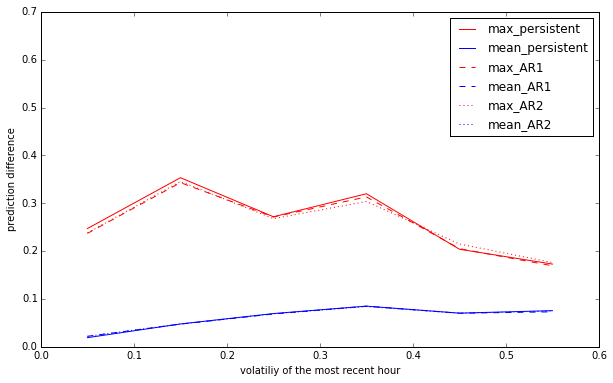

In [36]:
fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)

ax1.plot(middlebinvalue,maxdifflist_persistent,color='red',label='max_persistent')
ax1.plot(middlebinvalue,meandifflist_persistent,color='blue',label = 'mean_persistent')
ax1.plot(middlebinvalue,maxdifflist_AR1,color='red',label='max_AR1',linestyle='--')
ax1.plot(middlebinvalue,meandifflist_AR1,color='blue',label = 'mean_AR1',linestyle='--')
ax1.plot(middlebinvalue,maxdifflist_AR2,color='red',label='max_AR2',linestyle=':')
ax1.plot(middlebinvalue,meandifflist_AR2,color='blue',label = 'mean_AR2',linestyle=':')
#ax1.plot(df.tsLocal.map(lambda x: x.time()),df.expectedr*df.mpower,color='green')
ax1.set_xlabel('volatiliy of the most recent hour')
ax1.set_ylabel('prediction difference')
ax1.set_ylim(0,0.7)
ax1.legend()

In [37]:
[mean_persistent,max_persistent,mean_AR1,max_AR1,mean_AR2,max_AR2]

[0.031504063489934127,
 0.35353327345058949,
 0.033307733162920607,
 0.34324078120969104,
 0.033311827076393269,
 0.3457091056450855]

Here one can see that the persistent model works best. Non-linear model is needed. The only most recent output is necessary.

## Complex model: SVR

In [38]:
feature_names = ['r-1']
d_train = Data_train
d_test = Data_test
d_train = d_train.loc[:,['tsLocal','power','mpower','V-s','r']+feature_names].dropna()
d_test = d_test.loc[:,['tsLocal','power','mpower','V-s','r']+feature_names].dropna()

X_train, y_train = d_train.loc[:,feature_names], d_train.loc[:,'r']
X_test, y_test = d_test.loc[:,feature_names], d_test.loc[:,'r']

In [39]:
from sklearn.svm import SVR
mod = SVR(C=10.0, epsilon=0.01).fit(X_train,y_train)
d_test['power_predict'] = (mod.predict(X_test))*d_test.loc[:,'mpower']
d_test['power_predict'] = d_test['power_predict']*(d_test['power_predict']<d_test['mpower'])+d_test['mpower']*(d_test['power_predict']>=d_test['mpower'])
d_test['power_predict'] = 0*(d_test['power_predict']<0)+d_test['power_predict']*(d_test['power_predict']>=0)
l = d_test.loc[:,'power']-d_test['power_predict']
[mean_set1,max_set1] = [np.mean(np.absolute(l)),np.max(np.absolute(l))]

In [40]:
d=d_test
meandifflist = [0]*numbins
maxdifflist = [0]*numbins
for i in range(0,numbins):
    dd = d[(d['V-s']>=0.1*i)&(d['V-s']<=0.1*(i+1))]
    l = dd['power']-dd['power_predict']
    meandifflist[i] = np.mean(np.absolute(l))
    maxdifflist[i] = np.max(np.absolute(l))
    
maxdifflist_set1 = maxdifflist
meandifflist_set1 = meandifflist

In [41]:
[mean_set1,max_set1]

[0.031645173736184834, 0.35213609284902514]

Tuning

(C=1.0, epsilon=0.1) = [0.042305194634086475, 0.3291139832019836]

(C=1.0, epsilon=0.05) = [0.033517589251016902, 0.34376281138370768]

(C=1.0, epsilon=0.01) = [0.030820058708938298, 0.35391136118510991]

(C=1.0, epsilon=0.005) = [0.030738257673745356, 0.35460946098007839]

(C=2.0, epsilon=0.01) = [0.030823620939861743, 0.35369815494443924]

(C=5.0, epsilon=0.01) = [0.030806222982790055, 0.35358676685817492]

(C=10.0, epsilon=0.01) = [0.030804738553494974, 0.35302548002263268]


In [42]:
feature_names = ['r-1']
feature_names = feature_names + ['s','DBW']

d_train = Data_train
d_test = Data_test
d_train = d_train.loc[:,['tsLocal','power','mpower','V-s','r']+feature_names].dropna()
d_test = d_test.loc[:,['tsLocal','power','mpower','V-s','r']+feature_names].dropna()

#extra scaling to make SVR behave well
d_train['DBW'] = d_train['DBW']/365.0
d_test['DBW'] = d_test['DBW']/365.0

X_train, y_train = d_train.loc[:,feature_names], d_train.loc[:,'r']
X_test, y_test = d_test.loc[:,feature_names], d_test.loc[:,'r']

In [43]:
from sklearn.svm import SVR
mod = SVR(C=10.0, epsilon=0.01).fit(X_train,y_train)
d_test['power_predict'] = (mod.predict(X_test))*d_test.loc[:,'mpower']
d_test['power_predict'] = d_test['power_predict']*(d_test['power_predict']<d_test['mpower'])+d_test['mpower']*(d_test['power_predict']>=d_test['mpower'])
d_test['power_predict'] = 0*(d_test['power_predict']<0)+d_test['power_predict']*(d_test['power_predict']>=0)
l = d_test.loc[:,'power']-d_test['power_predict']
[mean_set2,max_set2] = [np.mean(np.absolute(l)),np.max(np.absolute(l))]

In [44]:
d=d_test
meandifflist = [0]*numbins
maxdifflist = [0]*numbins
for i in range(0,numbins):
    dd = d[(d['V-s']>=0.1*i)&(d['V-s']<=0.1*(i+1))]
    l = dd['power']-dd['power_predict']
    meandifflist[i] = np.mean(np.absolute(l))
    maxdifflist[i] = np.max(np.absolute(l))
    
maxdifflist_set2 = maxdifflist
meandifflist_set2 = meandifflist

In [45]:
feature_names = ['r-1']
feature_names = feature_names + ['s','DBW']
feature_names = feature_names + ['V-s']

d_train = Data_train
d_test = Data_test
d_train = d_train.loc[:,['tsLocal','power','mpower','r']+feature_names].dropna()
d_test = d_test.loc[:,['tsLocal','power','mpower','r']+feature_names].dropna()

#extra scaling to make SVR behave well
d_train['DBW'] = d_train['DBW']/365.0
d_test['DBW'] = d_test['DBW']/365.0

X_train, y_train = d_train.loc[:,feature_names], d_train.loc[:,'r']
X_test, y_test = d_test.loc[:,feature_names], d_test.loc[:,'r']

In [46]:
from sklearn.svm import SVR
mod = SVR(C=10.0, epsilon=0.01).fit(X_train,y_train)
d_test['power_predict'] = (mod.predict(X_test))*d_test.loc[:,'mpower']
d_test['power_predict'] = d_test['power_predict']*(d_test['power_predict']<d_test['mpower'])+d_test['mpower']*(d_test['power_predict']>=d_test['mpower'])
d_test['power_predict'] = 0*(d_test['power_predict']<0)+d_test['power_predict']*(d_test['power_predict']>=0)
l = d_test.loc[:,'power']-d_test['power_predict']
[mean_set3,max_set3] = [np.mean(np.absolute(l)),np.max(np.absolute(l))]

In [47]:
d_test.shape

(3360, 9)

In [48]:
d=d_test
meandifflist = [0]*numbins
maxdifflist = [0]*numbins
for i in range(0,numbins):
    dd = d[(d['V-s']>=0.1*i)&(d['V-s']<=0.1*(i+1))]
    l = dd['power']-dd['power_predict']
    meandifflist[i] = np.mean(np.absolute(l))
    maxdifflist[i] = np.max(np.absolute(l))
    
maxdifflist_set3 = maxdifflist
meandifflist_set3 = meandifflist

In [49]:
feature_names = ['r-1']
feature_names = feature_names + ['s','DBW']
#feature_names = feature_names + ['V-s']
feature_names = feature_names +['cldCvr-1','dewPt-1','feelsLike-1','precip-1','relHum-1','sfcPres-1','snowfall-1',
                        'spcHum-1','temp-1','windSpd-1','wetBulb-1']

d_train = Data_train
d_test = Data_test
d_train = d_train.loc[:,['tsLocal','power','mpower','V-s','r']+feature_names].dropna()
d_test = d_test.loc[:,['tsLocal','power','mpower','V-s','r']+feature_names].dropna()

#extra scaling to make SVR behave well
d_train['DBW'] = d_train['DBW']/365.0
d_test['DBW'] = d_test['DBW']/365.0

X_train, y_train = d_train.loc[:,feature_names], d_train.loc[:,'r']
X_test, y_test = d_test.loc[:,feature_names], d_test.loc[:,'r']

In [50]:
d_test.shape

(3353, 19)

In [51]:
from sklearn.svm import SVR
mod = SVR(C=10.0, epsilon=0.01).fit(X_train,y_train)
d_test['power_predict'] = (mod.predict(X_test))*d_test.loc[:,'mpower']
d_test['power_predict'] = d_test['power_predict']*(d_test['power_predict']<d_test['mpower'])+d_test['mpower']*(d_test['power_predict']>=d_test['mpower'])
d_test['power_predict'] = 0*(d_test['power_predict']<0)+d_test['power_predict']*(d_test['power_predict']>=0)
l = d_test.loc[:,'power']-d_test['power_predict']
[mean_set4,max_set4] = [np.mean(np.absolute(l)),np.max(np.absolute(l))]

In [52]:
d=d_test
meandifflist = [0]*numbins
maxdifflist = [0]*numbins
for i in range(0,numbins):
    dd = d[(d['V-s']>=0.1*i)&(d['V-s']<=0.1*(i+1))]
    l = dd['power']-dd['power_predict']
    meandifflist[i] = np.mean(np.absolute(l))
    maxdifflist[i] = np.max(np.absolute(l))
    
maxdifflist_set4 = maxdifflist
meandifflist_set4 = meandifflist

In [53]:
feature_names = ['r-1']
feature_names = feature_names + ['s','DBW']
feature_names = feature_names + ['V-s']
feature_names = feature_names +['cldCvr-1','dewPt-1','feelsLike-1','precip-1','relHum-1','sfcPres-1','snowfall-1',
                        'spcHum-1','temp-1','windSpd-1','wetBulb-1']

d_train = Data_train
d_test = Data_test
d_train = d_train.loc[:,['tsLocal','power','mpower','r']+feature_names].dropna()
d_test = d_test.loc[:,['tsLocal','power','mpower','r']+feature_names].dropna()

#extra scaling to make SVR behave well
d_train['DBW'] = d_train['DBW']/365.0
d_test['DBW'] = d_test['DBW']/365.0

X_train, y_train = d_train.loc[:,feature_names], d_train.loc[:,'r']
X_test, y_test = d_test.loc[:,feature_names], d_test.loc[:,'r']

In [54]:
from sklearn.svm import SVR
mod = SVR(C=10.0, epsilon=0.01).fit(X_train,y_train)
d_test['power_predict'] = (mod.predict(X_test))*d_test.loc[:,'mpower']
d_test['power_predict'] = d_test['power_predict']*(d_test['power_predict']<d_test['mpower'])+d_test['mpower']*(d_test['power_predict']>=d_test['mpower'])
d_test['power_predict'] = 0*(d_test['power_predict']<0)+d_test['power_predict']*(d_test['power_predict']>=0)
l = d_test.loc[:,'power']-d_test['power_predict']
[mean_set5,max_set5] = [np.mean(np.absolute(l)),np.max(np.absolute(l))]

In [55]:
d=d_test
meandifflist = [0]*numbins
maxdifflist = [0]*numbins
for i in range(0,numbins):
    dd = d[(d['V-s']>=0.1*i)&(d['V-s']<=0.1*(i+1))]
    l = dd['power']-dd['power_predict']
    meandifflist[i] = np.mean(np.absolute(l))
    maxdifflist[i] = np.max(np.absolute(l))
    
maxdifflist_set5 = maxdifflist
meandifflist_set5 = meandifflist

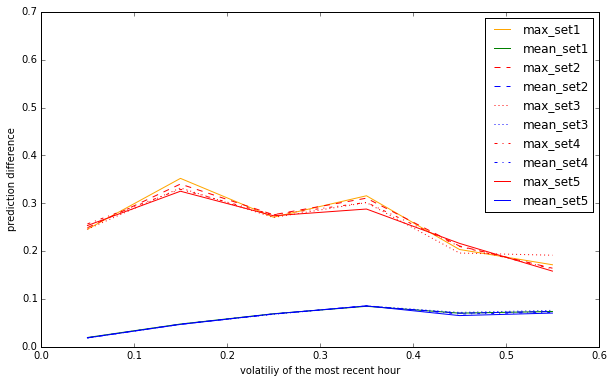

In [56]:
fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)

ax1.plot(middlebinvalue,maxdifflist_set1,color='orange',label='max_set1')
ax1.plot(middlebinvalue,meandifflist_set1,color='green',label = 'mean_set1')
ax1.plot(middlebinvalue,maxdifflist_set2,color='red',label='max_set2',linestyle='--')
ax1.plot(middlebinvalue,meandifflist_set2,color='blue',label = 'mean_set2',linestyle='--')
ax1.plot(middlebinvalue,maxdifflist_set3,color='red',label='max_set3',linestyle=':')
ax1.plot(middlebinvalue,meandifflist_set3,color='blue',label = 'mean_set3',linestyle=':')
ax1.plot(middlebinvalue,maxdifflist_set4,color='red',label='max_set4',linestyle='-.')
ax1.plot(middlebinvalue,meandifflist_set4,color='blue',label = 'mean_set4',linestyle='-.')
ax1.plot(middlebinvalue,maxdifflist_set5,color='red',label='max_set5')
ax1.plot(middlebinvalue,meandifflist_set5,color='blue',label = 'mean_set5')
#ax1.plot(df.tsLocal.map(lambda x: x.time()),df.expectedr*df.mpower,color='green')
ax1.set_xlabel('volatiliy of the most recent hour')
ax1.set_ylabel('prediction difference')
ax1.set_ylim(0,0.7)
ax1.legend()

In [57]:
[mean_set1,max_set1,mean_set2,max_set2,mean_set3,max_set3,mean_set4,max_set4,mean_set5,max_set5]

[0.031645173736184834,
 0.35213609284902514,
 0.03108508883815209,
 0.34027465837627413,
 0.031045632744493772,
 0.33221858596338827,
 0.031106637766476857,
 0.32926997741305608,
 0.030946536247799947,
 0.32527142049463009]

## Complex model: GBR

In [58]:
#Set I
feature_names = ['r-1']
d_train = Data_train
d_test = Data_test
d_train = d_train.loc[:,['tsLocal','power','mpower','V-s','r']+feature_names].dropna()
d_test = d_test.loc[:,['tsLocal','power','mpower','V-s','r']+feature_names].dropna()

X_train, y_train = d_train.loc[:,feature_names], d_train.loc[:,'r']
X_test, y_test = d_test.loc[:,feature_names], d_test.loc[:,'r']

In [59]:
#Gradient Boosting Regression
###############################################################################
# Fit regression model
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.05, 'loss': 'lad'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

d_test['power_predict'] = (clf.predict(X_test))*d_test.loc[:,'mpower']
d_test['power_predict'] = d_test['power_predict']*(d_test['power_predict']<d_test['mpower'])+d_test['mpower']*(d_test['power_predict']>=d_test['mpower'])
d_test['power_predict'] = 0*(d_test['power_predict']<0)+d_test['power_predict']*(d_test['power_predict']>=0)
l = d_test.loc[:,'power']-d_test['power_predict']
[mean_set1,max_set1] = [np.mean(np.absolute(l)),np.max(np.absolute(l))]

In [60]:
d=d_test
meandifflist = [0]*numbins
maxdifflist = [0]*numbins
for i in range(0,numbins):
    dd = d[(d['V-s']>=0.1*i)&(d['V-s']<=0.1*(i+1))]
    l = dd['power']-dd['power_predict']
    meandifflist[i] = np.mean(np.absolute(l))
    maxdifflist[i] = np.max(np.absolute(l))
    
maxdifflist_set1 = maxdifflist
meandifflist_set1 = meandifflist

In [61]:
[mean_set1,max_set1]

[0.031799745116646815, 0.34800506442571688]

Tuning

(n_estimators=1000, max_depth = 4, min_sample_split = 1, learning_rate = 0.01) = [0.018170701146602655, 0.30013690313456104]

(n_estimators=1000, max_depth = 3, min_sample_split = 1, learning_rate = 0.01) = [0.018222359362417093, 0.30818794358020457]

(n_estimators=1000, max_depth = 5, min_sample_split = 1, learning_rate = 0.01) = [0.018224416683996981, 0.30009807107182235]

(n_estimators=500, max_depth = 4, min_sample_split = 1, learning_rate = 0.01) = [0.018276289211960658, 0.29998021274314018]

(n_estimators=2000, max_depth = 4, min_sample_split = 1, learning_rate = 0.01) = [0.018176200985892503, 0.30013763323581583]

(n_estimators=1000, max_depth = 4, min_sample_split = 2, learning_rate = 0.01) = [0.018170701146602655, 0.30013690313456104]

(n_estimators=1000, max_depth = 4, min_sample_split = 2, learning_rate = 0.05) = [0.018168739462917523, 0.30010999363143559]

(n_estimators=1000, max_depth = 4, min_sample_split = 2, learning_rate = 0.1) = [0.01816837728271091, 0.30031980249732465]


In [62]:
#Set 2
feature_names = ['r-1']
feature_names = feature_names + ['s','DBW']

d_train = Data_train
d_test = Data_test
d_train = d_train.loc[:,['tsLocal','power','mpower','V-s','r']+feature_names].dropna()
d_test = d_test.loc[:,['tsLocal','power','mpower','V-s','r']+feature_names].dropna()

#extra scaling to make SVR behave well
d_train['DBW'] = d_train['DBW']/365.0
d_test['DBW'] = d_test['DBW']/365.0

X_train, y_train = d_train.loc[:,feature_names], d_train.loc[:,'r']
X_test, y_test = d_test.loc[:,feature_names], d_test.loc[:,'r']

In [63]:
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.05, 'loss': 'lad'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

d_test['power_predict'] = (clf.predict(X_test))*d_test.loc[:,'mpower']
d_test['power_predict'] = d_test['power_predict']*(d_test['power_predict']<d_test['mpower'])+d_test['mpower']*(d_test['power_predict']>=d_test['mpower'])
d_test['power_predict'] = 0*(d_test['power_predict']<0)+d_test['power_predict']*(d_test['power_predict']>=0)
l = d_test.loc[:,'power']-d_test['power_predict']
[mean_set2,max_set2] = [np.mean(np.absolute(l)),np.max(np.absolute(l))]

In [64]:
d=d_test
meandifflist = [0]*numbins
maxdifflist = [0]*numbins
for i in range(0,numbins):
    dd = d[(d['V-s']>=0.1*i)&(d['V-s']<=0.1*(i+1))]
    l = dd['power']-dd['power_predict']
    meandifflist[i] = np.mean(np.absolute(l))
    maxdifflist[i] = np.max(np.absolute(l))
    
maxdifflist_set2 = maxdifflist
meandifflist_set2 = meandifflist

In [65]:
#Set 3
feature_names = ['r-1']
feature_names = feature_names + ['s','DBW']
feature_names = feature_names + ['V-s']

d_train = Data_train
d_test = Data_test
d_train = d_train.loc[:,['tsLocal','power','mpower','r']+feature_names].dropna()
d_test = d_test.loc[:,['tsLocal','power','mpower','r']+feature_names].dropna()

#extra scaling to make SVR behave well
d_train['DBW'] = d_train['DBW']/365.0
d_test['DBW'] = d_test['DBW']/365.0

X_train, y_train = d_train.loc[:,feature_names], d_train.loc[:,'r']
X_test, y_test = d_test.loc[:,feature_names], d_test.loc[:,'r']

In [66]:
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.05, 'loss': 'lad'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

d_test['power_predict'] = (clf.predict(X_test))*d_test.loc[:,'mpower']
d_test['power_predict'] = d_test['power_predict']*(d_test['power_predict']<d_test['mpower'])+d_test['mpower']*(d_test['power_predict']>=d_test['mpower'])
d_test['power_predict'] = 0*(d_test['power_predict']<0)+d_test['power_predict']*(d_test['power_predict']>=0)
l = d_test.loc[:,'power']-d_test['power_predict']
[mean_set3,max_set3] = [np.mean(np.absolute(l)),np.max(np.absolute(l))]

In [67]:
d=d_test
meandifflist = [0]*numbins
maxdifflist = [0]*numbins
for i in range(0,numbins):
    dd = d[(d['V-s']>=0.1*i)&(d['V-s']<=0.1*(i+1))]
    l = dd['power']-dd['power_predict']
    meandifflist[i] = np.mean(np.absolute(l))
    maxdifflist[i] = np.max(np.absolute(l))
    
maxdifflist_set3 = maxdifflist
meandifflist_set3 = meandifflist

In [68]:
#Set 4
feature_names = ['r-1']
feature_names = feature_names + ['s','DBW']
#feature_names = feature_names + ['V-s']
feature_names = feature_names +['cldCvr-1','dewPt-1','feelsLike-1','precip-1','relHum-1','sfcPres-1','snowfall-1',
                        'spcHum-1','temp-1','windSpd-1','wetBulb-1']

d_train = Data_train
d_test = Data_test
d_train = d_train.loc[:,['tsLocal','power','mpower','V-s','r']+feature_names].dropna()
d_test = d_test.loc[:,['tsLocal','power','mpower','V-s','r']+feature_names].dropna()

#extra scaling to make SVR behave well
d_train['DBW'] = d_train['DBW']/365.0
d_test['DBW'] = d_test['DBW']/365.0

X_train, y_train = d_train.loc[:,feature_names], d_train.loc[:,'r']
X_test, y_test = d_test.loc[:,feature_names], d_test.loc[:,'r']

In [69]:
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.05, 'loss': 'lad'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

d_test['power_predict'] = (clf.predict(X_test))*d_test.loc[:,'mpower']
d_test['power_predict'] = d_test['power_predict']*(d_test['power_predict']<d_test['mpower'])+d_test['mpower']*(d_test['power_predict']>=d_test['mpower'])
d_test['power_predict'] = 0*(d_test['power_predict']<0)+d_test['power_predict']*(d_test['power_predict']>=0)
l = d_test.loc[:,'power']-d_test['power_predict']
[mean_set4,max_set4] = [np.mean(np.absolute(l)),np.max(np.absolute(l))]

In [70]:
d=d_test
meandifflist = [0]*numbins
maxdifflist = [0]*numbins
for i in range(0,numbins):
    dd = d[(d['V-s']>=0.1*i)&(d['V-s']<=0.1*(i+1))]
    l = dd['power']-dd['power_predict']
    meandifflist[i] = np.mean(np.absolute(l))
    maxdifflist[i] = np.max(np.absolute(l))
    
maxdifflist_set4 = maxdifflist
meandifflist_set4 = meandifflist

In [71]:
#Set 5
feature_names = ['r-1']
feature_names = feature_names + ['s','DBW']
feature_names = feature_names + ['V-s']
feature_names = feature_names +['cldCvr-1','dewPt-1','feelsLike-1','precip-1','relHum-1','sfcPres-1','snowfall-1',
                        'spcHum-1','temp-1','windSpd-1','wetBulb-1']

d_train = Data_train
d_test = Data_test
d_train = d_train.loc[:,['tsLocal','power','mpower','r']+feature_names].dropna()
d_test = d_test.loc[:,['tsLocal','power','mpower','r']+feature_names].dropna()

#extra scaling to make SVR behave well
d_train['DBW'] = d_train['DBW']/365.0
d_test['DBW'] = d_test['DBW']/365.0

X_train, y_train = d_train.loc[:,feature_names], d_train.loc[:,'r']
X_test, y_test = d_test.loc[:,feature_names], d_test.loc[:,'r']

In [72]:
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.05, 'loss': 'lad'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

d_test['power_predict'] = (clf.predict(X_test))*d_test.loc[:,'mpower']
d_test['power_predict'] = d_test['power_predict']*(d_test['power_predict']<d_test['mpower'])+d_test['mpower']*(d_test['power_predict']>=d_test['mpower'])
d_test['power_predict'] = 0*(d_test['power_predict']<0)+d_test['power_predict']*(d_test['power_predict']>=0)
l = d_test.loc[:,'power']-d_test['power_predict']
[mean_set5,max_set5] = [np.mean(np.absolute(l)),np.max(np.absolute(l))]

In [73]:
d=d_test
meandifflist = [0]*numbins
maxdifflist = [0]*numbins
for i in range(0,numbins):
    dd = d[(d['V-s']>=0.1*i)&(d['V-s']<=0.1*(i+1))]
    l = dd['power']-dd['power_predict']
    meandifflist[i] = np.mean(np.absolute(l))
    maxdifflist[i] = np.max(np.absolute(l))
    
maxdifflist_set5 = maxdifflist
meandifflist_set5 = meandifflist

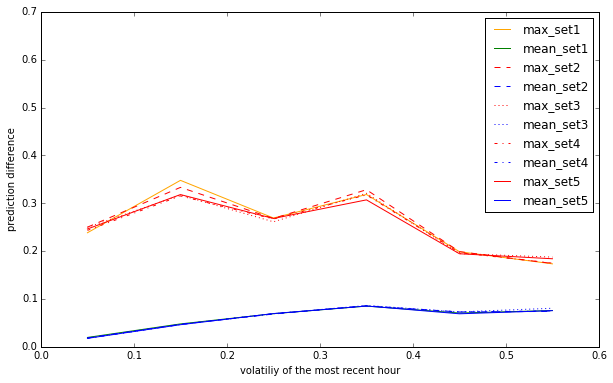

In [74]:
fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)

ax1.plot(middlebinvalue,maxdifflist_set1,color='orange',label='max_set1')
ax1.plot(middlebinvalue,meandifflist_set1,color='green',label = 'mean_set1')
ax1.plot(middlebinvalue,maxdifflist_set2,color='red',label='max_set2',linestyle='--')
ax1.plot(middlebinvalue,meandifflist_set2,color='blue',label = 'mean_set2',linestyle='--')
ax1.plot(middlebinvalue,maxdifflist_set3,color='red',label='max_set3',linestyle=':')
ax1.plot(middlebinvalue,meandifflist_set3,color='blue',label = 'mean_set3',linestyle=':')
ax1.plot(middlebinvalue,maxdifflist_set4,color='red',label='max_set4',linestyle='-.')
ax1.plot(middlebinvalue,meandifflist_set4,color='blue',label = 'mean_set4',linestyle='-.')
ax1.plot(middlebinvalue,maxdifflist_set5,color='red',label='max_set5')
ax1.plot(middlebinvalue,meandifflist_set5,color='blue',label = 'mean_set5')
#ax1.plot(df.tsLocal.map(lambda x: x.time()),df.expectedr*df.mpower,color='green')
ax1.set_xlabel('volatiliy of the most recent hour')
ax1.set_ylabel('prediction difference')
ax1.set_ylim(0,0.7)
ax1.legend()

In [75]:
[mean_set1,max_set1,mean_set2,max_set2,mean_set3,max_set3,mean_set4,max_set4,mean_set5,max_set5]

[0.031799745116646815,
 0.34800506442571688,
 0.030913273591167585,
 0.3332943674799328,
 0.030761468502673545,
 0.32097285038460499,
 0.030374574142952453,
 0.31755865430005625,
 0.030239680031905133,
 0.31828792208068657]

# STOP HERE

[0.030358628450202919, 0.31515683476443956]


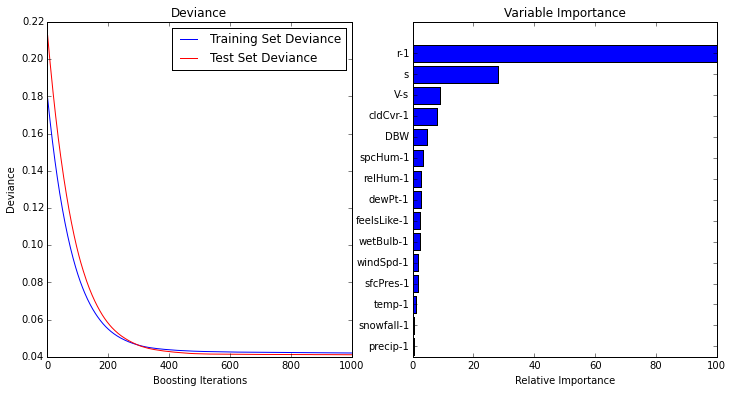

In [76]:
#Gradient Boosting Regression
###############################################################################
# Fit regression model
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.01, 'loss': 'lad'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

d_test['power_predict'] = (clf.predict(X_test))*d_test.loc[:,'mpower']
d_test['power_predict'] = d_test['power_predict']*(d_test['power_predict']<d_test['mpower'])+d_test['mpower']*(d_test['power_predict']>=d_test['mpower'])
d_test['power_predict'] = 0*(d_test['power_predict']<0)+d_test['power_predict']*(d_test['power_predict']>=0)
l = d_test.loc[:,'power']-d_test['power_predict']
print [np.mean(np.absolute(l)),np.max(np.absolute(l))]

#mae_r = mean_absolute_error(y_test, clf.predict(X_test))
#print("MAE: %.4f" % mae_r)

###############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

###############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, [feature_names[i] for i in sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


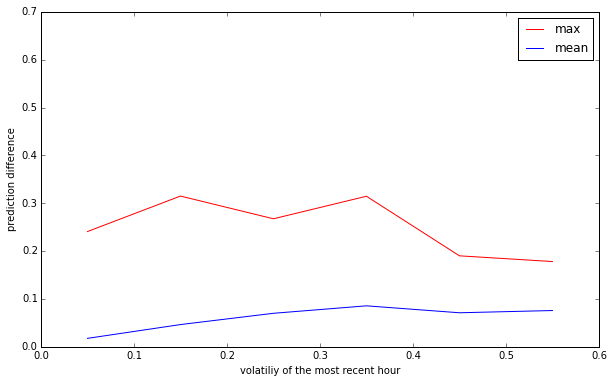

In [77]:
d=d_test
numbins = int(math.ceil(np.max(d['V-s'])/0.1))
meandifflist = [0]*numbins
maxdifflist = [0]*numbins
middlebinvalue = [0.1*i+0.05 for i in range(0,numbins)]
for i in range(0,numbins):
    dd = d[(d['V-s']>=0.1*i)&(d['V-s']<=0.1*(i+1))]
    l = dd['power']-dd['power_predict']
    meandifflist[i] = np.mean(np.absolute(l))
    maxdifflist[i] = np.max(np.absolute(l))
    
fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)

ax1.plot(middlebinvalue,maxdifflist,color='red',label='max')
ax1.plot(middlebinvalue,meandifflist,color='blue',label = 'mean')
#ax1.plot(df.tsLocal.map(lambda x: x.time()),df.expectedr*df.mpower,color='green')
ax1.set_xlabel('volatiliy of the most recent hour')
ax1.set_ylabel('prediction difference')
ax1.set_ylim(0,0.7)
ax1.legend()

## Model 6: Incorporate s, DBW, and V-s using Recurrent Neural Networks (RNN)

In [78]:
from theano import *

In [79]:
#Check out RNN http://www.nehalemlabs.net/prototype/blog/2013/10/10/implementing-a-recurrent-neural-network-in-python/.
#This requiress a continuous string of data?

import theano
import theano.tensor as T
import numpy as np
import cPickle
import random
import matplotlib.pyplot as plt

class RNN(object):

	def __init__(self, nin, n_hidden, nout):
		rng = np.random.RandomState(1234)
		W_uh = np.asarray(
			rng.normal(size=(nin, n_hidden), scale= .01, loc = .0), dtype = theano.config.floatX)
		W_hh = np.asarray(
			rng.normal(size=(n_hidden, n_hidden), scale=.01, loc = .0), dtype = theano.config.floatX)
		W_hy = np.asarray(
			rng.normal(size=(n_hidden, nout), scale =.01, loc=0.0), dtype = theano.config.floatX)
		b_hh = np.zeros((n_hidden,), dtype=theano.config.floatX)
		b_hy = np.zeros((nout,), dtype=theano.config.floatX)
		self.activ = T.nnet.sigmoid
		lr = T.scalar()
		u = T.matrix()
		t = T.scalar()

		W_uh = theano.shared(W_uh, 'W_uh')
		W_hh = theano.shared(W_hh, 'W_hh')
		W_hy = theano.shared(W_hy, 'W_hy')
		b_hh = theano.shared(b_hh, 'b_hh')
		b_hy = theano.shared(b_hy, 'b_hy')

		h0_tm1 = theano.shared(np.zeros(n_hidden, dtype=theano.config.floatX))

		h, _ = theano.scan(self.recurrent_fn, sequences = u,
					   outputs_info = [h0_tm1],
					   non_sequences = [W_hh, W_uh, W_hy, b_hh])

		y = T.dot(h[-1], W_hy) + b_hy
		#modify cost to be l-1 norm
		cost = (np.absolute(t - y)).mean(axis=0).sum()
		predict = y.mean(axis=0).sum()

		gW_hh, gW_uh, gW_hy,\
		   gb_hh, gb_hy = T.grad(
			   cost, [W_hh, W_uh, W_hy, b_hh, b_hy])

		self.train_step = theano.function([u, t, lr], cost,
							on_unused_input='warn',
							updates=[(W_hh, W_hh - lr*gW_hh),
									 (W_uh, W_uh - lr*gW_uh),
									 (W_hy, W_hy - lr*gW_hy),
									 (b_hh, b_hh - lr*gb_hh),
									 (b_hy, b_hy - lr*gb_hy)],
							allow_input_downcast=True)
        
		self.predict = theano.function(inputs=[u],outputs=predict)

	def recurrent_fn(self, u_t, h_tm1, W_hh, W_uh, W_hy, b_hh):
		h_t = self.activ(T.dot(h_tm1, W_hh) + T.dot(u_t, W_uh) + b_hh)
		return h_t


In [80]:
d_train = Data_train
d_test = Data_test
#feature_names = ['r-1']#,'s','DBW','V-s']
feature_names = ['r-1','s','DBW','V-s']
d_train = d_train.loc[:,['tsLocal','power','mpower','r']+feature_names].dropna()
d_test = d_test.loc[:,['tsLocal','power','mpower','r']+feature_names].dropna()

#extra scaling to make SVR behave well
d_train['DBW'] = d_train['DBW']/365.0
d_test['DBW'] = d_test['DBW']/365.0

X_train, y_train = d_train.loc[:,feature_names], d_train.loc[:,'r']
X_test, y_test = d_test.loc[:,feature_names], d_test.loc[:,'r']

In [81]:
d = d_train.append(d_test)

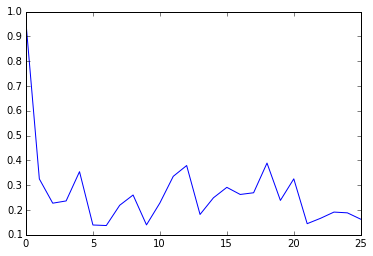

In [82]:
rnn = RNN(3, 10, 1) #number-in, hidden, number-out
lr = 0.01
e = 1
vals = []
clist = []
vlist = []
for i in xrange(d.shape[0]):
    u = np.matrix(d[['s','DBW','V-s']].iloc[i])
    #u = np.random.rand(5,1)
    t = d['r'].iloc[i]
    c = rnn.train_step(u, t, lr)
    clist.append(c)
    v = rnn.predict(u)
    vlist.append(v)
    #print "iteration {0}: {1}".format(i, np.sqrt(c))
    e = 0.1*np.sqrt(c) + 0.9*e
    if i % 1000 == 0:
        vals.append(e)
plt.plot(vals)
#plt.savefig('plots/error.png')

In [83]:
#consider only error in d_test
np.mean(clist[(d_train.shape[0]):])

0.089582490327213174

In [84]:
d['r-predict'] = vlist

In [85]:
d['power_predict'] = d['r-predict']*d.loc[:,'mpower']
d['power_predict'] = d['power_predict']*(d['power_predict']<d['mpower'])+d['mpower']*(d['power_predict']>=d['mpower'])
d['power_predict'] = 0*(d['power_predict']<0)+d['power_predict']*(d['power_predict']>=0)
l = d.loc[:,'power']-d.loc[:,'power_predict']
l = l[(d_train.shape[0]):]
[np.mean(np.absolute(l)),np.max(np.absolute(l))]

[0.046170721852751423, 0.3920125464966146]

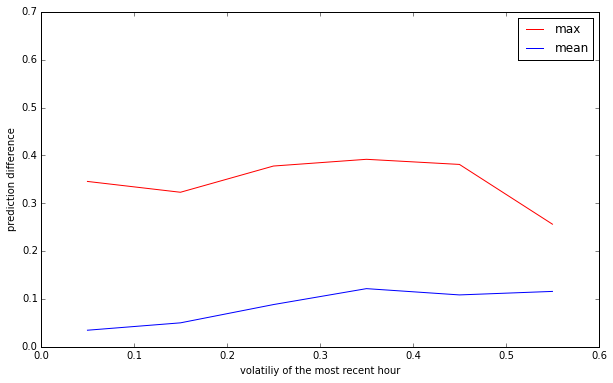

In [86]:
l = d['power_predict']
d_test['power_predict'] = l[(d_train.shape[0]):]
d=d_test
numbins = int(math.ceil(np.max(d['V-s'])/0.1))
meandifflist = [0]*numbins
maxdifflist = [0]*numbins
middlebinvalue = [0.1*i+0.05 for i in range(0,numbins)]
for i in range(0,numbins):
    dd = d[(d['V-s']>=0.1*i)&(d['V-s']<=0.1*(i+1))]
    l = dd['power']-dd['power_predict']
    meandifflist[i] = np.mean(np.absolute(l))
    maxdifflist[i] = np.max(np.absolute(l))
    
fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)

ax1.plot(middlebinvalue,maxdifflist,color='red',label='max')
ax1.plot(middlebinvalue,meandifflist,color='blue',label = 'mean')
#ax1.plot(df.tsLocal.map(lambda x: x.time()),df.expectedr*df.mpower,color='green')
ax1.set_xlabel('volatiliy of the most recent hour')
ax1.set_ylabel('prediction difference')
ax1.set_ylim(0,0.7)
ax1.legend()

In this simple RNN, we can only tweak the number of hidden layers.

A shortcoming of this model is that we do not a continuous stream of values. RNN losts power here